In [10]:
import os

from collections import deque
import importlib
import torch as T
import gymnasium as gym

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

In [11]:
env_id = "MountainCar-v0"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  2
Sample observation [ 0.12325313 -0.04705064]


In [12]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [13]:
layer1 = 64
layer2 = 128
gamma = 0.89
learning_rate = 0.0001
episodes = 100_000
avg_win_size = 100
epi_results = deque(maxlen=avg_win_size)

agent = policygradient.ReInforce(s_size, a_size, layer1, layer2, gamma = gamma)

In [14]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient.pth')

In [16]:
train = False
if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards\n')

    for epi in range(episodes):

        if not train:
            print("set train flag to True for Training")
            break

        s = env.reset()[0]
        done, trunc = False, False
        rewards, states , actions = [], [], []
        win , steps = 0,0

        while not any([done, trunc]):

            states.append(s)
            obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

            with T.no_grad():
                p_vals = agent.policy_net(obs)
                p_vals = T.squeeze(p_vals)

            p_vals = p_vals.detach().cpu().numpy()
            a = np.random.choice(a_size, p=p_vals)

            s_, r, done ,trunc , _  = env.step(a)
            
            steps +=1
            if s_[0]>=0.5 :
                r = 10
                win = 1
                done = True
            else:
                r = 100*s_[1]*s_[1]

            if steps>= 200:
                done = True
            
            actions.append(a)
            rewards.append(r)

            s=np.copy(s_)

        epi_results.append(win)
        loss = agent.train(states, rewards, actions)

        log_file.write(f'{epi},{loss:.2f},{np.sum(rewards):.2f}\n')

        if epi%100==0:
            clear_output()
        if epi%10==0:
            print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_wins:{np.mean(epi_results):8.2f}')
        if np.mean(np.mean(epi_results))>=0.95:
            break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi:04400 reward:   29.48 loss:   14.19 mean_wins:    0.93
Saving Agent as .\models\MountainCar-v0_policygradient.pth


In [17]:
eval_agent =policygradient.ReInforce(s_size, a_size, layer1, layer2, gamma = gamma)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Loss')

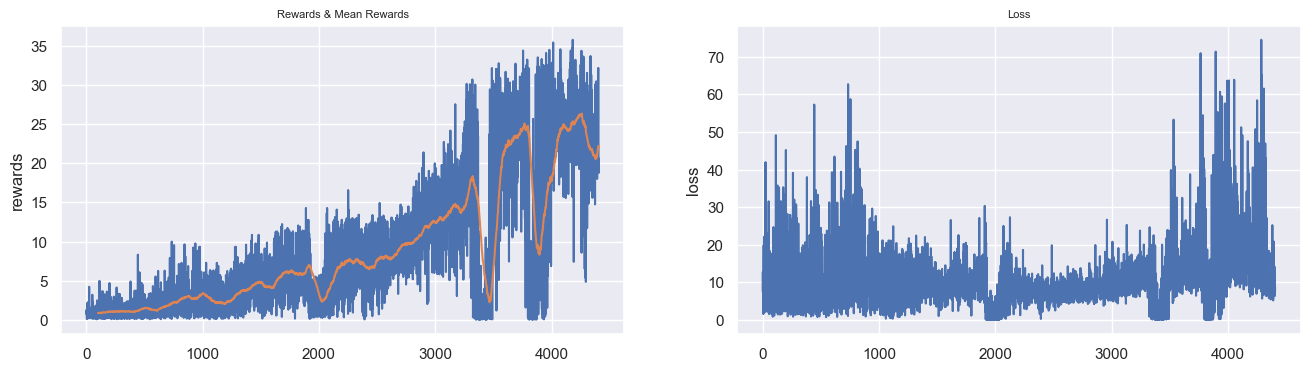

In [18]:
fig,ax=plt.subplots(1,2,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['loss'],ax = ax[1])
ax[1].set_title('Loss',fontsize=8)

In [19]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    win = 0
    
    while not any([term, trunc]):

        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.argmax(p_vals)
        
        s, r, term ,trunc , _  = eval_env.step(a)
        if s[0]>=0.5:
            win =1
        
    print(f'{epi = } result {win}')
eval_env.close()

epi = 0 result 1
epi = 1 result 1
epi = 2 result 1
epi = 3 result 1
epi = 4 result 1
epi = 5 result 1
epi = 6 result 1
epi = 7 result 1
epi = 8 result 1
epi = 9 result 1
